# Train Low Test Models

This notebook is a streamlined notebook for generating minima of low test accuracy through three different means:
- Dataset Poisoning
- Adding Noise to Data
- Decreasing Dataset Sizes

## Imports

In [1]:
# Standard library
import copy
import os
import sys
import time

# Third-party
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Local package imports
from minima_volume.dataset_funcs import (
    prepare_datasets,
    save_dataset,
    save_model,
)
from minima_volume.train_funcs import evaluate, train

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Input Parameters

In [2]:

# ==============================
# Base Input Parameters
# ==============================
# --- SEEDS ---
data_seed = 12            
model_seed = 2           

# --- Training configuration ---
epochs = 500            

# --- Dataset configuration ---
base_data_size = 400      
dataset_type = "poison"   
dataset_quantities = [0, 10, 20, 50, 100]

# --- Output configuration ---
base_output_dir = ""     
save_generated_dataset = True   
save_generated_models = True    


## Model + Dataset Specific Code

This is for specific code.

In [3]:
# User specifies the model module name
from minima_volume.models import swiss_model_data as model_module

test_dataset_size = 2000

# Generate dataset
x_base, y_base, x_test, y_test = model_module.get_dataset(
    base_data_size=base_data_size,
    dataset_quantities=dataset_quantities,
    test_dataset_size=test_dataset_size,
    noise=0.3, # default swiss params
    extra_pts=1000,
    dataset_type=dataset_type,
    seed=data_seed
)

# Swiss specific initialization parameters
input_dim = 2
output_dim = 1
hidden_dims = [32]*6

# Grab model
model_template = model_module.get_model(input_dim=input_dim, hidden_dims=hidden_dims, output_dim=output_dim, device=device, seed=model_seed)

# Grab loss and metrics
loss_fn = model_module.get_loss_fn()
other_metrics = model_module.get_additional_metrics()

## Training

We generate the various datasets used to train our models here, before training them. We record the losses, and what each model was trained on.

In [4]:
# ==============================
# Prepare datasets
# ==============================
x_base_train, y_base_train, x_additional, y_additional = prepare_datasets(
    x_base=x_base,
    y_base=y_base,
    dataset_type=dataset_type,
    dataset_quantities=dataset_quantities,
    base_data_size=base_data_size,
    data_seed=data_seed,
    seed_1=None,
    seed_2=None,
)

x_base_train = x_base_train.to(device)
y_base_train = y_base_train.to(device)
x_additional = x_additional.to(device)
y_additional = y_additional.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

# ==============================
# Training loop
# ==============================
all_models = []

for additional_data in dataset_quantities:
    # Assemble training dataset
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    # Initialize model (defined in the model-specific file)
    torch.manual_seed(model_seed)
    model = copy.deepcopy(model_template)
    optimizer = optim.AdamW(model.parameters(), lr=1e-3)
    batch_size = len(x_train)

    # Train model
    train_loss, train_other_metrics, test_loss, test_other_metrics = train(
        model = model,
        x_train = x_train, y_train = y_train,
        x_test = x_test, y_test = y_test,
        loss_fn = loss_fn,
        metrics = other_metrics,
        optimizer = optimizer,
        epochs=epochs,
        batch_size=batch_size,
        verbose_every=100,
    )
    
    # Build dictionary dynamically for additional metrics
    train_metrics_dict = {}
    test_metrics_dict = {}
    if train_other_metrics is not None:
        # train_other_metrics is a list of dicts per epoch
        for metric_name in train_other_metrics[0].keys():  # keys from first epoch
            train_metrics_dict[f"train_{metric_name}"] = [m[metric_name] for m in train_other_metrics]
            test_metrics_dict[f"test_{metric_name}"] = [m[metric_name] for m in test_other_metrics]
    
    # Store results
    trained_model = {
        "model": model,
        "train_loss": train_loss,
        "test_loss": test_loss,
        "additional_data": additional_data,
        "dataset_type": dataset_type,
        **train_metrics_dict,  # dynamically include additional metrics
        **test_metrics_dict,
    }
    
    all_models.append(trained_model)

    print(f"Completed training with {additional_data} additional samples of {dataset_type}")

    # Free memory (important for large GPU datasets)
    del x_train, y_train
    torch.cuda.empty_cache()


Epoch 1/500: Train Loss 0.6961 | Test Loss 0.6933 | accs Train 0.4850 Test 0.5000
Epoch 100/500: Train Loss 0.5593 | Test Loss 0.5893 | accs Train 0.6725 Test 0.6633
Epoch 200/500: Train Loss 0.0084 | Test Loss 0.0291 | accs Train 0.9975 Test 0.9895
Epoch 300/500: Train Loss 0.0005 | Test Loss 0.0236 | accs Train 1.0000 Test 0.9945
Epoch 400/500: Train Loss 0.0002 | Test Loss 0.0259 | accs Train 1.0000 Test 0.9948
Epoch 500/500: Train Loss 0.0001 | Test Loss 0.0276 | accs Train 1.0000 Test 0.9948
Completed training with 0 additional samples of poison
Epoch 1/500: Train Loss 0.6967 | Test Loss 0.6933 | accs Train 0.4805 Test 0.5000
Epoch 100/500: Train Loss 0.5527 | Test Loss 0.5753 | accs Train 0.6415 Test 0.6262
Epoch 200/500: Train Loss 0.0768 | Test Loss 0.0872 | accs Train 0.9707 Test 0.9838
Epoch 300/500: Train Loss 0.0535 | Test Loss 0.0877 | accs Train 0.9829 Test 0.9655
Epoch 400/500: Train Loss 0.0337 | Test Loss 0.1018 | accs Train 0.9878 Test 0.9700
Epoch 500/500: Train Loss

Epoch 100/500: Train Loss 0.5593 | Test Loss 0.5893 | accs Train 0.6725 Test 0.6633


Epoch 200/500: Train Loss 0.0084 | Test Loss 0.0291 | accs Train 0.9975 Test 0.9895


Epoch 300/500: Train Loss 0.0005 | Test Loss 0.0236 | accs Train 1.0000 Test 0.9945


Epoch 400/500: Train Loss 0.0002 | Test Loss 0.0259 | accs Train 1.0000 Test 0.9948


Epoch 500/500: Train Loss 0.0001 | Test Loss 0.0276 | accs Train 1.0000 Test 0.9948
Completed training with 0 additional samples of poison
Epoch 1/500: Train Loss 0.6967 | Test Loss 0.6933 | accs Train 0.4805 Test 0.5000


Epoch 100/500: Train Loss 0.5527 | Test Loss 0.5753 | accs Train 0.6415 Test 0.6262


Epoch 200/500: Train Loss 0.0768 | Test Loss 0.0872 | accs Train 0.9707 Test 0.9838


Epoch 300/500: Train Loss 0.0535 | Test Loss 0.0877 | accs Train 0.9829 Test 0.9655


Epoch 400/500: Train Loss 0.0337 | Test Loss 0.1018 | accs Train 0.9878 Test 0.9700


Epoch 500/500: Train Loss 0.0220 | Test Loss 0.1399 | accs Train 0.9951 Test 0.9630
Completed training with 10 additional samples of poison
Epoch 1/500: Train Loss 0.6976 | Test Loss 0.6933 | accs Train 0.4738 Test 0.5000


Epoch 100/500: Train Loss 0.5332 | Test Loss 0.5518 | accs Train 0.7119 Test 0.7192


Epoch 200/500: Train Loss 0.1215 | Test Loss 0.0908 | accs Train 0.9500 Test 0.9775


Epoch 300/500: Train Loss 0.0982 | Test Loss 0.0895 | accs Train 0.9619 Test 0.9712


Epoch 400/500: Train Loss 0.0837 | Test Loss 0.0818 | accs Train 0.9690 Test 0.9667


Epoch 500/500: Train Loss 0.0708 | Test Loss 0.0861 | accs Train 0.9714 Test 0.9688
Completed training with 20 additional samples of poison
Epoch 1/500: Train Loss 0.6979 | Test Loss 0.6933 | accs Train 0.4711 Test 0.5000


Epoch 100/500: Train Loss 0.5618 | Test Loss 0.5479 | accs Train 0.7022 Test 0.7137


Epoch 200/500: Train Loss 0.2898 | Test Loss 0.1549 | accs Train 0.8933 Test 0.9875


Epoch 300/500: Train Loss 0.2398 | Test Loss 0.1435 | accs Train 0.8956 Test 0.9610


Epoch 400/500: Train Loss 0.2359 | Test Loss 0.1226 | accs Train 0.9000 Test 0.9680


Epoch 500/500: Train Loss 0.2040 | Test Loss 0.1595 | accs Train 0.9089 Test 0.9493
Completed training with 50 additional samples of poison
Epoch 1/500: Train Loss 0.6964 | Test Loss 0.6933 | accs Train 0.4840 Test 0.5000


Epoch 100/500: Train Loss 0.5916 | Test Loss 0.5362 | accs Train 0.6840 Test 0.7372


Epoch 200/500: Train Loss 0.4387 | Test Loss 0.2658 | accs Train 0.8000 Test 0.9585


Epoch 300/500: Train Loss 0.3945 | Test Loss 0.2555 | accs Train 0.8180 Test 0.9263


Epoch 400/500: Train Loss 0.3694 | Test Loss 0.2547 | accs Train 0.8340 Test 0.9100


Epoch 500/500: Train Loss 0.3451 | Test Loss 0.2711 | accs Train 0.8500 Test 0.8958
Completed training with 100 additional samples of poison


## Training Summary

In [5]:
# ====================================
# Summary of Training Results
# ====================================
print("=== True Generalization ===")
for model_data in all_models:
    model = model_data["model"]
    additional_data = model_data["additional_data"]

    test_loss, test_metrics = evaluate(
        model=model,
        x_test=x_test,
        y_test=y_test,
        loss_fn=loss_fn,
        metrics=other_metrics
    )

    metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in test_metrics.items()])
    print(
        f"{additional_data:>4} samples | "
        f"Test Loss: {test_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
    )

print("\n=== Model Diagnostics by Training Data ===")
for additional_data in dataset_quantities:
    # Build dataset with this many additional samples
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    print(f"\nDataset type: {dataset_type}, additional samples: {additional_data}")

    for model_data in all_models:
        model = model_data["model"]
        model_additional_data = model_data["additional_data"]

        train_loss, train_metrics = evaluate(
            model=model,
            x_test=x_train,
            y_test=y_train,
            loss_fn=loss_fn,
            metrics=other_metrics
        )

        metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in train_metrics.items()])
        print(
            f" Model {model_additional_data:>4} | "
            f"Train Loss: {train_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
        )

    # Free memory if large
    del x_train, y_train
    torch.cuda.empty_cache()

=== True Generalization ===
   0 samples | Test Loss: 0.0276 | accs: 0.9948
  10 samples | Test Loss: 0.1399 | accs: 0.9630
  20 samples | Test Loss: 0.0861 | accs: 0.9688
  50 samples | Test Loss: 0.1595 | accs: 0.9493
 100 samples | Test Loss: 0.2711 | accs: 0.8958

=== Model Diagnostics by Training Data ===

Dataset type: poison, additional samples: 0
 Model    0 | Train Loss: 0.0001 | accs: 1.0000
 Model   10 | Train Loss: 0.0100 | accs: 1.0000
 Model   20 | Train Loss: 0.0279 | accs: 0.9975
 Model   50 | Train Loss: 0.0923 | accs: 0.9850
 Model  100 | Train Loss: 0.1670 | accs: 0.9825

Dataset type: poison, additional samples: 10
 Model    0 | Train Loss: 0.3122 | accs: 0.9756
 Model   10 | Train Loss: 0.0218 | accs: 0.9951
 Model   20 | Train Loss: 0.0471 | accs: 0.9854
 Model   50 | Train Loss: 0.1180 | accs: 0.9683
 Model  100 | Train Loss: 0.1883 | accs: 0.9659

Dataset type: poison, additional samples: 20
 Model    0 | Train Loss: 0.5861 | accs: 0.9524
 Model   10 | Train Los

### Model + Data Specific Verification

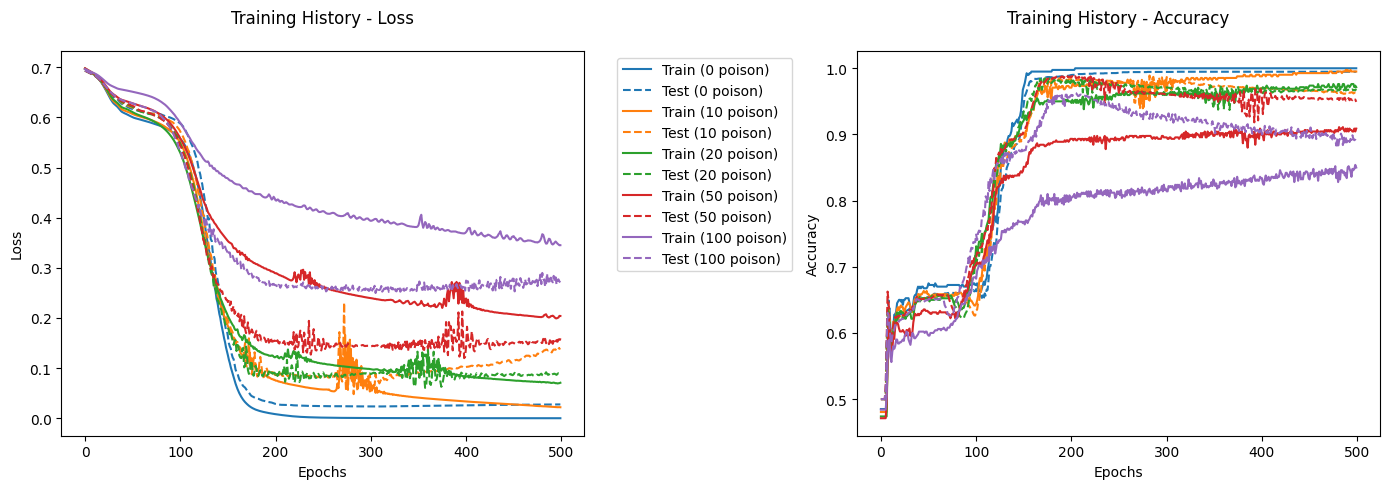

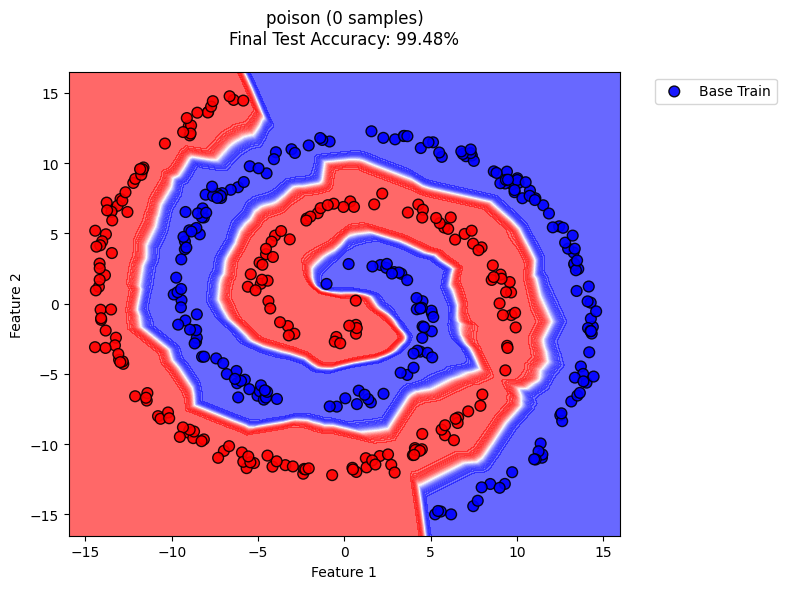

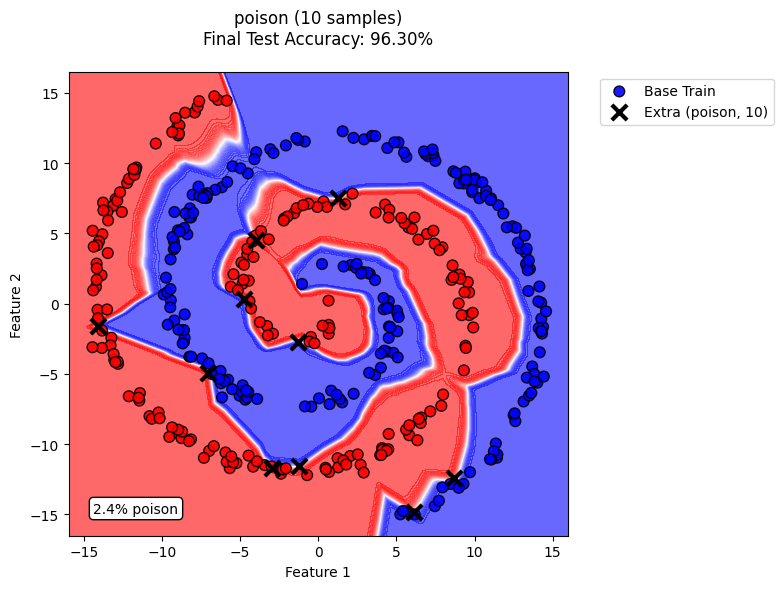

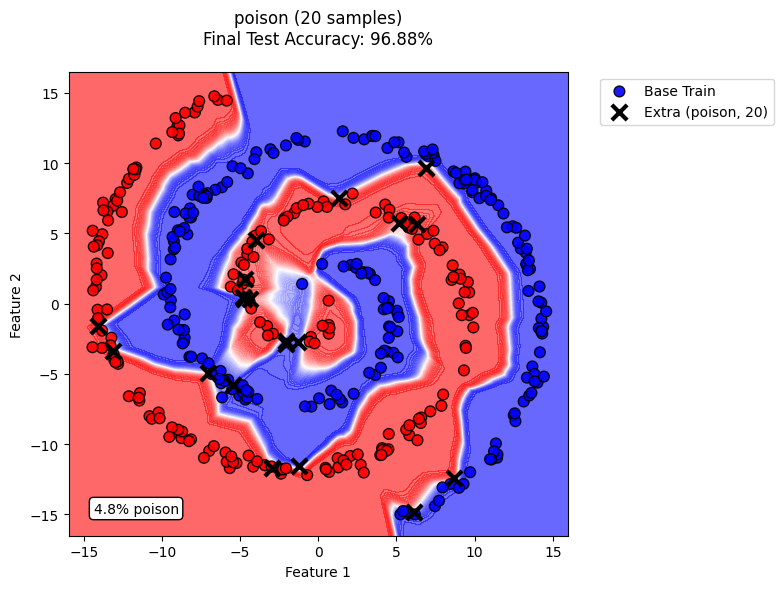

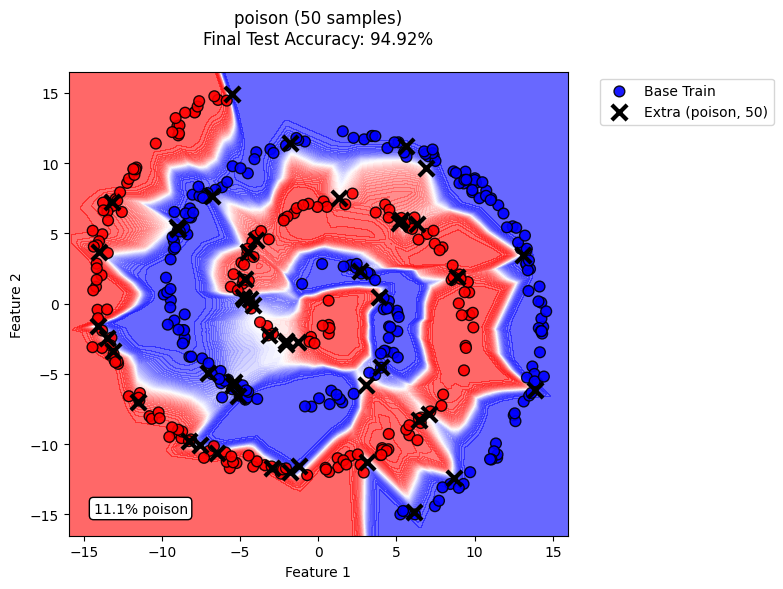

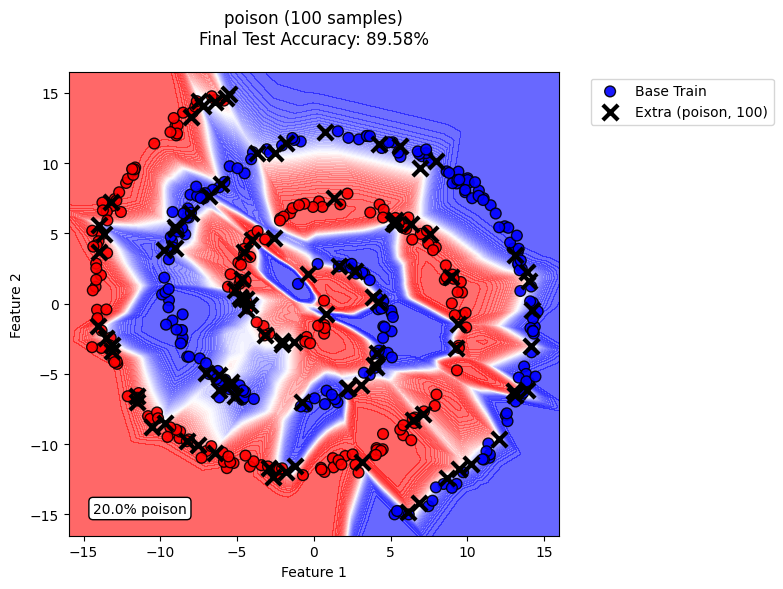

In [6]:
model_module.verify_model_results(
    all_models=all_models,
    x_base_train=x_base_train,
    y_base_train=y_base_train,
    x_additional=x_additional,
    y_additional=y_additional,
    x_test=x_test,
    y_test=y_test,
    dataset_quantities=dataset_quantities,
    dataset_type=dataset_type,
)

## Model Saving

In [7]:
# ====================================
# Save Datasets and Models
# ====================================
output_folder = "models_and_data"
# Save dataset (Possible to skip)
if save_generated_dataset:
    save_dataset(
        folder=output_folder,
        filename="dataset.pt",
        x_base_train=x_base_train,
        y_base_train=y_base_train,
        x_additional=x_additional,
        y_additional=y_additional,
        x_test=x_test,
        y_test=y_test,
        dataset_quantities=dataset_quantities,
        dataset_type=dataset_type,
    )
    print(f"Saved dataset to {output_folder}/dataset.pt")

# Save trained models
if save_generated_models:
    for model_data in all_models:
        filename = f"model_additional_{model_data['additional_data']}.pt"
        save_model(
            folder=output_folder,
            filename=filename,
            model=model_data["model"],
            train_loss=model_data["train_loss"],
            train_accs=model_data["train_accs"],
            test_loss=model_data["test_loss"],
            test_accs=model_data["test_accs"],
            additional_data=model_data["additional_data"],
            dataset_type=model_data["dataset_type"],
        )
        print(f"Saved model: {output_folder}/{filename}")

✅ Dataset saved to models_and_data\dataset.pt
Saved dataset to models_and_data/dataset.pt
✅ Model saved to models_and_data\model_additional_0.pt
Saved model: models_and_data/model_additional_0.pt
✅ Model saved to models_and_data\model_additional_10.pt
Saved model: models_and_data/model_additional_10.pt
✅ Model saved to models_and_data\model_additional_20.pt
Saved model: models_and_data/model_additional_20.pt
✅ Model saved to models_and_data\model_additional_50.pt
Saved model: models_and_data/model_additional_50.pt
✅ Model saved to models_and_data\model_additional_100.pt
Saved model: models_and_data/model_additional_100.pt
